# TO delete

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Telecom/IMA208/TP6 - calibration-20240325')
current_directory = os.getcwd()
print(current_directory)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Telecom/IMA208/TP6 - calibration-20240325


In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

The objective of this practical work is to implement the simple camera calibration method we saw in class. To do that, you will need a several pictures of a calibration pattern, which is chosen here to be a chessboard.

In the last part, you will furthermore compare you results with the ones of openCV calibration function.

# Part I: load data

First, you have to load several calibration images, which is done in the following cell. The images are provided with this notebook.

**Question:** how many images do you need to calibrate the camera?

**Answer:**

We need at least 3 images

**Fill** the gaps in the following cell to enter the world coordinates of the corners in the chessboard.

**Explain** why do you have to remove one of the world frame coordinate?

**Answer:**

We need to remove one coordinate (usually the Z axis) in order to obtain a Homography as a transformation between the real world homogenous coordinates and the 2d image homongenous coordinates

In [3]:
# First, you have to set the world coordinates of the corners in the chessboard, which we will call objpoints. We will consider that the cells of the chessboard have a length side of 1.
# Please note that you only have to take the inner corner of the chessbord, which correspond to full squares. Therefore, we will consider that there 7 row corners and 6 column corners.

objp = np.zeros((6*7,3), np.float32)
objp[:,:2] =  np.mgrid[0:7,0:6].T.reshape(-1,2)
#np.array([[[i,j]for j in range(6)] for i in range(7)]).reshape((6*7,2))   # 3D coordinates in real world space. A np.array, each column corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
objpoints = objp[:,:2] # Remove a useless dimension in the world coordinates. Explain : This allows us to have a homography as the mapping transformation

Now, **fill** the code below by entering the path of the folder in which you saved the image.

**Question:** What is the code below doing?

In [4]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
imgpoints = [] # 2D points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
images = glob.glob('Chessboards/*.jpg') # To be filled.
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(np.squeeze(corners2))

        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()
        print('found border !')



Output hidden; open in https://colab.research.google.com to view.

# Part II: camera calibration

The objective of this part is to perform the camera calibration using the algorithm we saw in class.

**Question:** Recall what camera calibration is. What parameters are we looking for?

**Answer:**

Camera calibration consists in finding the internsec parameters of the camera namely the camera calibration matrix K. We are specificallyy looking for $f_x,f_y,p_x,p_y$ and $s$

**Question:** Recall the main principles of the calibration algorithm we saw in class. What are the main steps that need to be implemented?

**Answer:**

First, we need to optain at least images of a regular structure which is typically chess board. 3 of these images has to be from different angles. Then for each image, we will compute the homography transformation matrix that mappes the 2 image obtained by the camera and the 3d world reduced world space(by removing the z axis). In order to do this, we can use the procedure that we studied in the last session : use RANSAC with DLT algorithm. Once we have obtained all the homographies, we then compute a vector $V$ and resolve the equation $Vb = 0$ and finally we get the camera calibration matrix K by conducting a Cholesky decompostion

To compute the calibration matrix, we first be able to compute some homographies between images. As you have already done so in the previous practical work, some code is provided below.

**Question:** What is the name of the homography estimation algorithm implemented below?

**Answer**

The name of the homography estimation algorithm implemented below is DLT (Direcet Linear Transformation

In [5]:
# Homography computation. See the previous pratical work for more details.
def svd_solve(A):
    """Solve a homogeneous least squares problem with the SVD
       method.

    Args:
       A: Matrix of constraints.
    Returns:
       The solution to the system.
    """
    U, S, V_t = np.linalg.svd(A)
    idx = np.argmin(S)

    least_squares_solution = V_t[idx]

    return least_squares_solution

def to_homogeneous(A):
    """Convert a stack of inhomogeneous vectors to a homogeneous
       representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A_hom = np.hstack((A, np.ones((N,1))))

    return A_hom

def calculate_normalization_matrix(data):
    """Calculates zero-centered, sqrt(2) distance transformed
       matrix transform for data.

       Args:
          data: Nx2 stack of data points
        Returns:
          The normalization matrix
    """
    if data.ndim != 2 or data.shape[-1] != 2:
        raise ValueError('Dataset must be a collection of 2D points')

    x, y = data[:, 0], data[:, 1]

    N = data.shape[0]

    x_mean, y_mean = x.mean(), y.mean()
    x_var, y_var = x.var(), y.var()

    # Form rescaling matrix so that data points will lie
    # sqrt(2) from the origin on average.
    s_x, s_y = np.sqrt(2. / x_var), np.sqrt(2. / y_var)

    norm_matrix = np.array([[s_x,  0., -s_x * x_mean],
                            [ 0., s_y, -s_y * y_mean],
                            [ 0.,  0.,            1.]])

    return norm_matrix

def calculate_homography(model, data):
    """Perform linear least squares to calculate homography between planar
       model and sensor data
    """
    N = model.shape[0]

    # Normalize data
    norm_matrix_model = calculate_normalization_matrix(model)
    norm_matrix_data  = calculate_normalization_matrix(data)

    model = to_homogeneous(model)
    data =  to_homogeneous(data)

    model_norm = np.dot(model, norm_matrix_model.T)
    data_norm = np.dot(data, norm_matrix_data.T)

    X, Y, x, y = model_norm[:,0], model_norm[:,1], data_norm[:,0], data_norm[:,1]

    # Mount homogeneous constraint matrix (See Burger pg. 11-13 for a derivation)
    A = np.zeros((N * 2, 9))

    x_component = np.zeros((N, 9))
    x_component[:, 0] = -X
    x_component[:, 1] = -Y
    x_component[:, 2] = -1.
    x_component[:, 6] =  x * X
    x_component[:, 7] =  x * Y
    x_component[:, 8] =  x

    y_component = np.zeros((N, 9))
    y_component[:, 3] = -X
    y_component[:, 4] = -Y
    y_component[:, 5] = -1.
    y_component[:, 6] =  y * X
    y_component[:, 7] =  y * Y
    y_component[:, 8] =  y

    # Note that all x-constraints precede all y-constraints for convenience of
    # representation.
    A[:N] = x_component
    A[N:] = y_component

    # Solve homogeneous system
    h_norm = svd_solve(A)

    # Reconstitute normalized homography
    H_norm = h_norm.reshape((3,3))

    # Denormalize
    H = np.dot(np.dot(np.linalg.pinv(norm_matrix_data), H_norm), norm_matrix_model)

    return H

In the following cell, compute the homographies for all the calibrations images in which you have extracted the corner coordinates.

**Question:** what is the format of the homographies variable? Explain.

**Answer:**

In [6]:
# Finds the homography for each image
homographies = []
for iData in range(len(imgpoints)):
    H =  calculate_homography(objpoints, imgpoints[iData])
    homographies.append(H)

In [7]:
homographies[0]

array([[ 1.62526799e+01,  1.19965499e+00, -2.66767925e+02],
       [-1.27784373e+00,  2.03529837e+01, -1.48192972e+02],
       [-8.40383597e-03,  2.96680023e-03, -5.59795925e-01]])

Now, let us start doing the calibration itself. To do that, as seen during the class, you will have to solve a linear system $\mathbf{Vb = 0}$. Recall how the $\mathbf{V}$ matrix is computed from the different homographies found previously.

**Answer:**
....


There are two constraints used for performing calibration: the orthogonality constraint and the normalization constraint. Both can be implemented using the $\mathbf{v}_{ij}$ matrix: $\mathbf{v}_{01}$ encodes the orthogonality constraints between $\mathbf{h}_0$ and $\mathbf{h}_1$, while the $\mathbf{v}_{00}$ and $\mathbf{v}_{11}$ encode the normalization constraint for $\mathbf{h}_0$ and $\mathbf{h}_1$. To write the constraints efficiently, code below the generation of $\mathbf{v}_{ij}$ (which will be later on used to implement the $\mathbf{V}$ matrix).

In [8]:
def generate_v_ij(H_stack, i, j):
    """Generate intrinsic ORTHOGONALITY constraints.

    Input:
    - H_stack: a matrix nx3x3 matrix, containing the homographies for the n different images.
    - i: an index of a column of H (starting from 0)
    - j: an index of a column of H (starting from 0)

    Output:
    v_ij: a nx6 matrix containing the orthogonality constraints for all the n images
    """
    M = H_stack.shape[0]

    v_ij = np.zeros((M, 6))

    v_ij[:, 0] = H_stack[:,0,i]*H_stack[:,0,j]
    v_ij[:, 1] = H_stack[:,0,i]*H_stack[:,1,j]+H_stack[:,1,i]*H_stack[:,0,j]
    v_ij[:, 2] = H_stack[:,1,i]*H_stack[:,1,j]
    v_ij[:, 3] = H_stack[:,2,i]*H_stack[:,0,j]+H_stack[:,0,i]*H_stack[:,2,j]
    v_ij[:, 4] = H_stack[:,2,i]*H_stack[:,1,j]+H_stack[:,1,i]*H_stack[:,2,j]
    v_ij[:, 5] = H_stack[:,2,i]*H_stack[:,2,j]

    return v_ij



Now, the generate_v_ij function can be used generate the full constraint matrix $\mathbf{V}$ and in turn find the intrinsic parameters.

**Question:** what are the intrinsic and the extrinsic parameters? What is distinguishing them?

**Answer:**

Fill the gaps in the function below to recover the instrinsics.

In [9]:
def recover_intrinsics(homographies):
    """Use computed homographies to calculate intrinsic matrix.
       Requires >= 3 homographies for a full 5-parameter intrinsic matrix.
    """
    M = len(homographies)

    # Stack homographies
    H_stack = np.zeros((M, 3, 3))
    for h, H in enumerate(homographies):
        H_stack[h] = H # H_stack, of size nx3x3 containing all the homographies for the n calibration images

    # Generate constraints

    v_00 = generate_v_ij(H_stack, 0, 0) # Normalization constraint
    v_01 = generate_v_ij(H_stack, 0, 1) # Orthogonality constraint
    v_11 = generate_v_ij(H_stack, 1, 1) # Normalization constraint


    # Generate the V matrix using v_01,v_00,v_11
    V = np.zeros((2 * M, 6))
    V[:M] = v_01      # Orthogonality constraint
    V[M:] = v_00-v_11 # Equality of norms constraint

    # Use SVD to solve the homogeneous system Vb = 0. You can directly the svd_solve function
    b = svd_solve(V)


    # Reshape the coefficients of b to transform them into the B symmetric matrix
    B0, B1, B2, B3, B4, B5 = b
    B = np.array([[B0, B1, B3],
                  [B1, B2, B4],
                  [B3, B4, B5]])


    # To find K from B, the explicit link between the B and K matrix is used. YOU DON'T NEED TO CHANGE ANYTHING UNTIL THE END OF THE FUNCTION
    # Form auxilliaries
    w = B0 * B2 * B5 - B1**2 * B5 - B0 * B4**2 + 2. * B1 * B3 * B4 - B2 * B3**2
    d = B0 * B2 - B1**2

    # Use Zhang's closed form solution for intrinsic parameters (Zhang, Appendix B, pg. 18)
    v0 = (B[0,1] * B[0,2] - B[0,0] * B[1,2]) / (B[0,0] * B[1,1] - B[0,1] * B[0,1])
    lambda_ = B[2,2] - (B[0,2] * B[0,2] + v0 * (B[0,1] * B[0,2] - B[0,0] * B[1,2])) / B[0,0]
    alpha = np.sqrt(lambda_ / B[0,0])
    beta = np.sqrt(lambda_ * B[0,0] / (B[0,0] * B[1,1] - B[0,1] * B[0,1]))
    gamma = -B[0,1] * alpha * alpha * beta / lambda_
    u0 = gamma * v0 / beta - B[0,2] * alpha * alpha / lambda_

    # Reconstitute intrinsic matrix
    K = np.array([[alpha, gamma, u0],
                  [   0.,  beta, v0],
                  [   0.,    0., 1.]])

    return K

**Question:** The above code use the closed form expression of Zhang for making the link between the $B$ and $K$ matrices. How would you have done otherwise?

**Answer:**

Apply the recover_instrinsics function on the homographies you already computed. What $K$ matrix are you obtaining?

In [10]:
# Infer the calibration matrix (intrinsics) from the already found homographies
K = recover_intrinsics(homographies)

In [11]:
K

array([[ 5.42429019e+02, -4.57166211e-01,  3.55748672e+02],
       [ 0.00000000e+00,  5.43087152e+02,  2.27293013e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Part III - recover the extrinsics

Now, let us compute the extrinsics! Look at the code below and fill the gaps.

**Question:** what is the purpose of the reorthogonalize function and why is it useful?

In [12]:
def to_homogeneous_3d(A):
    """Convert a stack of inhomogeneous vectors (without a Z component)
       to a homogeneous full-form representation.
    """
    if A.ndim != 2 or A.shape[-1] != 2:
        raise ValueError('Stacked vectors must be 2D inhomogeneous')

    N = A.shape[0]
    A_3d = np.hstack((A, np.zeros((N,1))))
    A_3d_hom = to_homogeneous(A_3d)

    return A_3d_hom

def reorthogonalize(R):
    """Determine least distance (Frobenius norm)rotation matrix
       from a rotation matrix that has drifted away from orthogonality.

    Args:
       R: The matrix to reorthogonalize.
    Returns:
       The reorthogonalized matrix.
    """
    U, S, V_t = np.linalg.svd(R)
    new_R = np.dot(U, V_t)
    return new_R

def recover_extrinsics(H, K):
    """Use computed homography and intrinsic matrix to calculate
       corresponding extrinsic matrix

    Args:
       H: 3x3 homography matrix
       K: 3x3 intrinsic matrix
    Returns:
       3x4 extrinsic matrix
    """
	# Obtain column vectors from homography matrix
    h0, h1, h2 = H[:,0], H[:,1], H[:,2]
    # h0, h1, h2 = ..., ..., ...

    # Compute the inverse of the already computed calibration matrix
    K_inv = np.linalg.pinv(K)

    # Form normalizer sc
    sc = np.linalg.norm(K_inv@h0)

    lambda_ = 1. / sc

    # Compute r0, r1, and t from the homography. r2 can be derived
    # by an orthogonality constraint (np.cross)

    r0 = lambda_ * K_inv@h0
    r1 = lambda_ * K_inv@h1
    r2 = np.cross(r0,r1)
    t  = lambda_ * K_inv@h2

    # Reconstitute the rotation component of the extrinsics and reorthogonalize
    R = np.vstack((r0, r1, r2)).T
    R = reorthogonalize(R)

    # Reconstitute full extrinsics
    E=np.hstack([R,t.reshape((t.size,1))])
    return E

Apply the above function to each homography to recover the extrinsics for each image based on fixed intrinsics. In addition, the projection error is computed for each image so that you can check the result quality. Conclusions?

In [13]:
def to_inhomogeneous(A):
    """Convert a stack of homogeneous vectors to an inhomogeneous
       representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A /= A[:,-1][:, np.newaxis]
    A_inhom = A[:,:-1]

    return A_inhom


# Recover the extrinsics for each image based on fixed intrinsics
extrinsic_matrices = []
for h, H in enumerate(homographies):
    E = recover_extrinsics(H,K)
    extrinsic_matrices.append(E)

    # Look at the projection error
    # Form projection matrix
    P = K@E

    model_hom_3d = to_homogeneous_3d(objpoints)
    predicted = np.dot(model_hom_3d, P.T) #x = PX but this writing enables to do the computations for all the points in a single operation
    predicted = to_inhomogeneous(predicted)
    data = imgpoints[h]

    nonlinear_sse_decomp = np.sqrt(np.sum((predicted - data)**2))
    print(nonlinear_sse_decomp)

10.374258633357162
10.748781512167975
15.090693181274036
7.146155252835039
9.212625921811503
41.7498432587399
38.709130532292136
11.768280418714872
13.04348225681339
8.712835732878563
14.878819698900802


In [14]:
print(extrinsic_matrices[2])

[[  0.93337562  -0.35407248   0.058674    -2.80261893]
 [  0.31707147   0.8900931    0.32741404  -2.88017787]
 [ -0.16815362  -0.28699643   0.94305748 -10.51142531]]


# Part IV - distortion

In this last part, we look for the deviations to the linear model by computing the distortions of the camera. For finding the distortion parameters, we will look for a maximum likelihood estimation. Fill the code in the function below.

In [15]:
def calculate_lens_distortion(model, all_data, K, extrinsic_matrices):
    """Calculate least squares estimate of distortion coefficients.

    Args:
       model: Nx2 planar points in the world frame (objpoints)
       all_data: M-length list of Nx2 sensor frame correspondences (imgpoints)
       K: 3x3 intrinsics matrix
       exrinsic_matrices: M-length list of 3x4 extrinsic matrices
    Returns:
       Radial distortion coefficients [k0, k1]
    """
    M = len(all_data)
    N = model.shape[0]

    model = to_homogeneous_3d(model)

    u_c, v_c = K[0,2], K[1,2]

    # Form radius vector
    r = np.zeros(2 * M * N)
    for e, E in enumerate(extrinsic_matrices):
        normalized_projection = np.dot(model, E.T)
        normalized_projection = to_inhomogeneous(normalized_projection)

        x_normalized_proj, y_normalized_proj = normalized_projection[:, 0], normalized_projection[:, 1]

        r_i = np.sqrt(x_normalized_proj**2+y_normalized_proj**2) # Compute the radius
        r[e*N:(e+1)*N] = r_i
    r[M*N:] = r[:M*N]

    # Form observation vector
    obs = np.zeros(2 * M * N)
    u_data, v_data = np.zeros(M * N), np.zeros(M * N)
    for d, data in enumerate(all_data):
        u_i, v_i = data[:, 0], data[:, 1]
        u_data[d*N:(d+1)*N] = u_i
        v_data[d*N:(d+1)*N] = v_i
    obs[:M*N] = u_data
    obs[M*N:] = v_data

    # Form prediction vector
    pred = np.zeros(2 * M * N)
    pred_centered = np.zeros(2 * M * N)
    u_pred, v_pred = np.zeros(M * N), np.zeros(M * N)
    for e, E in enumerate(extrinsic_matrices):
        P =   K@E#Compute the projection matrix using K and E
        projection = np.dot(model,P.T)#Project all the 3D points in model using P
        projection = to_inhomogeneous(projection)
        u_pred_i = projection[:, 0]
        v_pred_i = projection[:, 1]

        u_pred[e*N:(e+1)*N] = u_pred_i
        v_pred[e*N:(e+1)*N] = v_pred_i
    pred[:M*N] = u_pred
    pred[M*N:] = v_pred
    pred_centered[:M*N] = u_pred - u_c
    pred_centered[M*N:] = v_pred - v_c

    # Form distortion coefficient constraint matrix
    D = np.zeros((2 * M * N, 2))
    D[:, 0] = pred_centered * r**2
    D[:, 1] = pred_centered * r**4

    # Form values (difference between sensor observations and predictions)
    b = obs - pred

    # Use pseudoinverse technique to compute least squares solution for distortion coefficients
    D_inv = np.linalg.pinv(D)
    k = np.dot(D_inv, b)

    return k

**Question:** in the above function, what is the distortion model used?

**Answer:**

Launch the above code to find the distortion parameters and plot the undistorted images. How good do you find the results? Explain how they could be improved.

**Answer:**

In [16]:
k = calculate_lens_distortion(objpoints, imgpoints, K, extrinsic_matrices)

In [17]:
print(k)

[ 0.02723124 -1.07680142]


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7c762d8b50c0>)

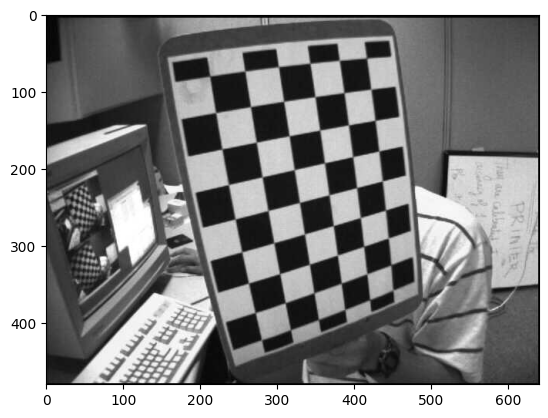

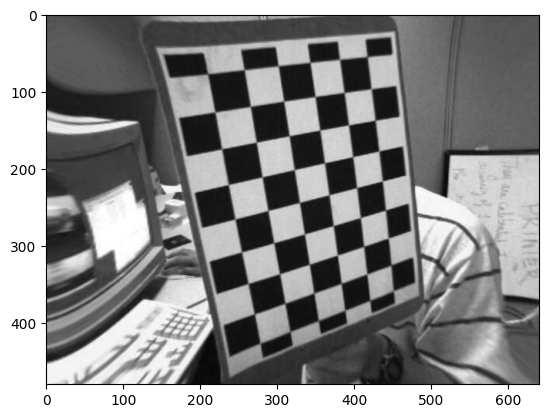

In [18]:
img = cv.imread('Chessboards/left14.jpg')
dst = cv.undistort(img, K,np.array([k[0],k[1],0,0,0]))
plt.imshow(img)
plt.figure(),plt.imshow(dst)

# Part V: comparison with openCV calibration result.

Now, we will use openCV calibration function to compare their results with ours. The above cell enables to do so. Compare your calibration matrix, rotation and translation with the result. Conclusions ?

Remark: to obtain the rotation matrices, you can use cv.Rodrigues(rvecs[k])[0]

In [19]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space. List (length = nb of images) of np.array, each of size = 3 (corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
imgpoints = [] # 2d points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
images = glob.glob('Chessboards/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Answer:**

In [20]:
ret, K_cv, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [21]:
print(cv.Rodrigues(rvecs[2])[0])

[[-0.92086474  0.36672175  0.13237558]
 [-0.31481472 -0.89968619  0.30241768]
 [ 0.22999962  0.23681199  0.94393869]]


In [22]:
tvecs[2]

array([[3.03685642],
       [2.74656588],
       [9.90005138]])

In [23]:
extrinsic_matrices[2] # This is matrix [R,t] but we have -R and -t maybe convention ?

array([[  0.93337562,  -0.35407248,   0.058674  ,  -2.80261893],
       [  0.31707147,   0.8900931 ,   0.32741404,  -2.88017787],
       [ -0.16815362,  -0.28699643,   0.94305748, -10.51142531]])

In [24]:
K # (same K as before)

array([[ 5.42429019e+02, -4.57166211e-01,  3.55748672e+02],
       [ 0.00000000e+00,  5.43087152e+02,  2.27293013e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In the following cell, the original image and its distorted version using openCV estimation is plotted. Compare with your results. What could explain the differences? You can also use the last cell to compute the projection error.

**Answer:**

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7c762d6a0c40>)

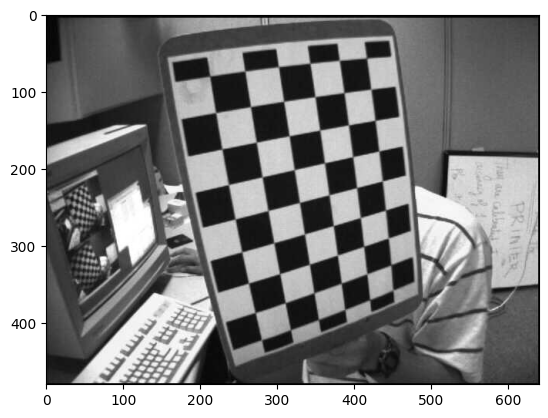

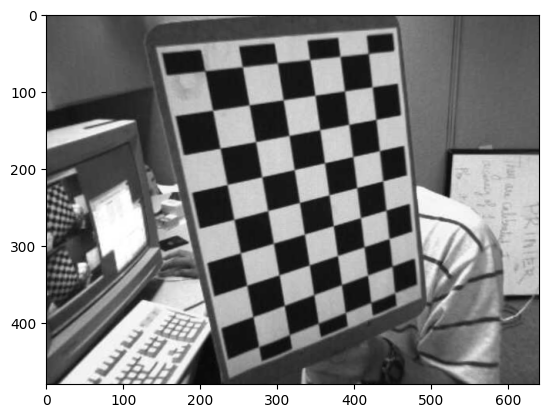

In [25]:
img = cv.imread('Chessboards/left14.jpg')
dst = cv.undistort(img, K, dist, None, K)
plt.imshow(img)
plt.figure(),plt.imshow(dst)

In [35]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error when using distortion coefficients obtained with cv: {}".format(mean_error/len(objpoints)) )

total error when using distortion coefficients obtained with cv: 2.424868563951574


In [36]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, np.array([k[0],k[1],0,0,0]))
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error when using distortion coefficients obtained with our simplified model: {}".format(mean_error/len(objpoints)) )

total error when using distortion coefficients obtained with our simplified model: 2.531311369580495
